In [100]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [101]:
# import dataset (comes with colab!)
data = np.loadtxt(open('C:/Users/Zlswo/VsCode Projects/DeepUnderstandingOfDeepLearning/sample_data/mnist_train_small.csv','rb'),delimiter=',')

# extract labels (number IDs) and remove from data
labels = data[:,0]
data   = data[:,1:]

In [102]:
# normalize the data to a range of [0 1]
dataNorm = data / np.max(data)

In [103]:
# Step 1: convert to tensor
dataT   = torch.tensor( dataNorm ).float()
labelsT = torch.tensor( labels ).long() # long = int64

# Step 2: use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(dataT, labelsT, test_size=.1)


# Step 3: convert into PyTorch Datasets
train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)

# Step 4: translate into dataloader objects
batchsize    = 32
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

In [104]:
# create a class for the model
def createTheMNISTNet(nUnits,nLayers):
  class mnistNet(nn.Module):
    def __init__(self, nUnits,nLayers):
        super().__init__()
        # create dictionary to store the layers
        self.layers = nn.ModuleDict()
        self.nLayers = nLayers

      ### input layer
        self.input = nn.Linear(784,nUnits)

        ### hidden layers
        for i in range(nLayers):
            self.layers[f'fc{i}'] = nn.Linear(nUnits,nUnits)
      
      ### output layer
        self.layers['output'] = nn.Linear(nUnits,10)

    # forward pass
    def forward(self,x):
      x = F.relu( self.input(x) )
      # hidden layers
      for i in range(self.nLayers):
        x = F.relu( self.layers[f'fc{i}'](x) )

      # return output layer
      x = self.layers['output'](x)
      return x
      # return torch.log_softmax( self.output(x),axis=1 )
      # NEW HERE: log-softmax the output, because I'm using NLLLoss instead of CrossEntropyLoss
  
  # create the model instance
  net = mnistNet(nUnits,nLayers)
  
  # loss function
  lossfun = nn.NLLLoss()

  # optimizer
  optimizer = torch.optim.SGD(net.parameters(),lr=.01)

  return net,lossfun,optimizer

In [105]:
# generate an instance of the model and inspect it
nUnitsPerLayer = 12
nLayers = 4
net, lossfun, optimizer = createTheMNISTNet(nUnitsPerLayer,nLayers)
net

mnistNet(
  (layers): ModuleDict(
    (fc0): Linear(in_features=12, out_features=12, bias=True)
    (fc1): Linear(in_features=12, out_features=12, bias=True)
    (fc2): Linear(in_features=12, out_features=12, bias=True)
    (fc3): Linear(in_features=12, out_features=12, bias=True)
    (output): Linear(in_features=12, out_features=10, bias=True)
  )
  (input): Linear(in_features=784, out_features=12, bias=True)
)

In [106]:
# test the model with one batch
net,lossfun,optimizer = createTheMNISTNet(nUnitsPerLayer,nLayers)

X,y = next(iter(train_loader))
yHat = net(X)

# values are log-probability of each number (0-9)
# print(torch.exp(yHat))

# now let's compute the loss
loss = lossfun(yHat,y)
print(' ')
print('Loss:')
print(loss)

 
Loss:
tensor(-0.1294, grad_fn=<NllLossBackward0>)


In [107]:
# a function that trains the model

def function2trainTheModel(nUnitsPerLayer,nLayers):

  # number of epochs
  numepochs = 60
  
  # create a new model
  net,lossfun,optimizer = createTheMNISTNet(nUnitsPerLayer,nLayers)

  # initialize losses
  losses    = torch.zeros(numepochs)
  trainAcc  = []
  testAcc   = []
  net, lossfun, optimizer = createTheMNISTNet(nUnitsPerLayer, nLayers)

  # loop over epochs
  for epochi in range(numepochs):

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute accuracy
      matches = torch.argmax(yHat,axis=1) == y     # booleans (false/true)
      matchesNumeric = matches.float()             # convert to numbers (0/1)
      accuracyPct = 100*torch.mean(matchesNumeric) # average and x100
      batchAcc.append( accuracyPct )               # add to list of accuracies
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    # Store average accuracy and loss per epoch for this configuration
      trainAcc.append(np.mean(batchAcc))
      losses[epochi] = np.mean(batchLoss)

    # test accuracy
      X,y = next(iter(test_loader)) # extract X,y from test dataloader
      with torch.no_grad():
        yHat = net(X)
      
    # compare the following really long line of code to the training accuracy lines
      testAcc.append ( 100 * torch.mean((torch.argmax(yHat, axis=1) == y).float()).item() )


  # end epochs

  # function output
  return trainAcc,testAcc,losses,net


In [108]:
nUnitsPerLayer = np.arange(50,251,50)
nLayers = range(1,4)  
accuracies = np.zeros((2, len(nUnitsPerLayer), len(nLayers)))

for nUnitsIndex, nUnits in enumerate(nUnitsPerLayer):
    for nLayersIndex, nLayer in enumerate(nLayers):
        # Create and train a fresh model
        trainAcc,testAcc,losses,net = function2trainTheModel(nUnitsPerLayer[nUnitsIndex],nLayers[nLayersIndex])

        # Store the results (average of final 5 epochs)
        accuracies[0,nUnits,nLayer] = np.mean(trainAcc[-5:])
        accuracies[1,nUnits,nLayer] = np.mean(testAcc[-5:])

        print(f'Finished units {nUnitsIndex+1}/{len(nUnitsPerLayer)} and layers {nLayersIndex+1}/{len(nLayersIndex)}')

IndexError: index 50 is out of bounds for axis 1 with size 5

TypeError: unsupported format string passed to numpy.ndarray.__format__

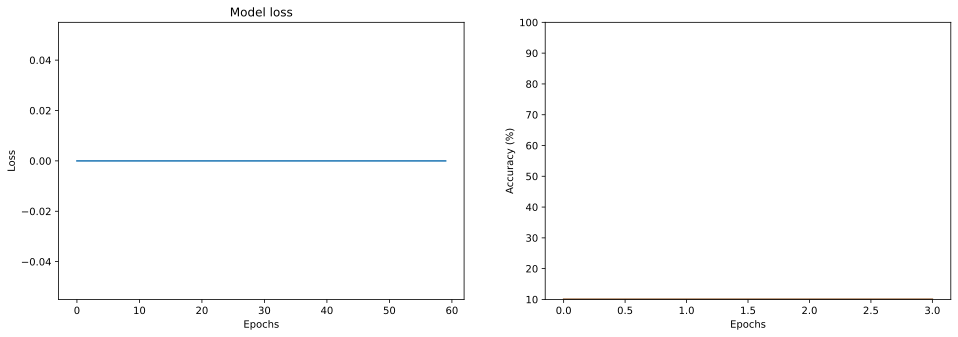

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(losses)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
# ax[0].set_ylim([0,3])
ax[0].set_title('Model loss')

ax[1].plot(trainAcc,label='Train')
ax[1].plot(testAcc,label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_ylim([10,100])
ax[1].set_title(f'Final model test accuracy: {testAcc[-1]:.2f}%')
ax[1].legend()

plt.show()